In [30]:
# IMPORTS
import glob, os, sys, h5py
import numpy as np
sys.path.insert(0,'../../')
sys.path.insert(0,'/Library/TeX/texbin/')
sys.path.insert(0,'../../WaveformAnalysis')
sys.path.insert(0,'/home/tb829/project/purity-monitor/WaveformAnalysis/')
from Gat_HPC import Gat_HPC as Gat
from scipy.signal import find_peaks, find_peaks_cwt, peak_widths, peak_prominences
from natsort import natsorted

import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.dpi']= 100

In [32]:
FILE = r'/gpfs/gibbs/project/david_moore/ab2935/Data/20220811/SRS_Gain_200/3Vpp_0.2V_interval/0.5kHz/mca_keith_30.00OV_0.h5'
f = h5py.File(FILE, 'r')  
ch2 = f.get('ch2')
for key in ch2.keys(): 
    df = np.array(ch2.get(key))
h = df
hx = np.arange(0,len(h),1)

In [33]:
def rebin(hx,h,bins):
    bins = int(bins)
    h_rebin=[]
    for i in range(int(len(h)/bins)):
        start_idx=i*bins
        end_idx=(i+1)*bins
        h_rebin.append(np.sum(h[start_idx:end_idx]))
    hx_rebin=range(len(h_rebin))
    return np.array(hx_rebin), np.array(h_rebin)

In [34]:
#x, y = rebin(hx,h,40)
x,y = hx, h

In [35]:
pind, pdict = find_peaks(y, prominence=2000)
print(pind)
print(pdict)

[387]
{'prominences': array([2264.]), 'left_bases': array([100]), 'right_bases': array([754])}


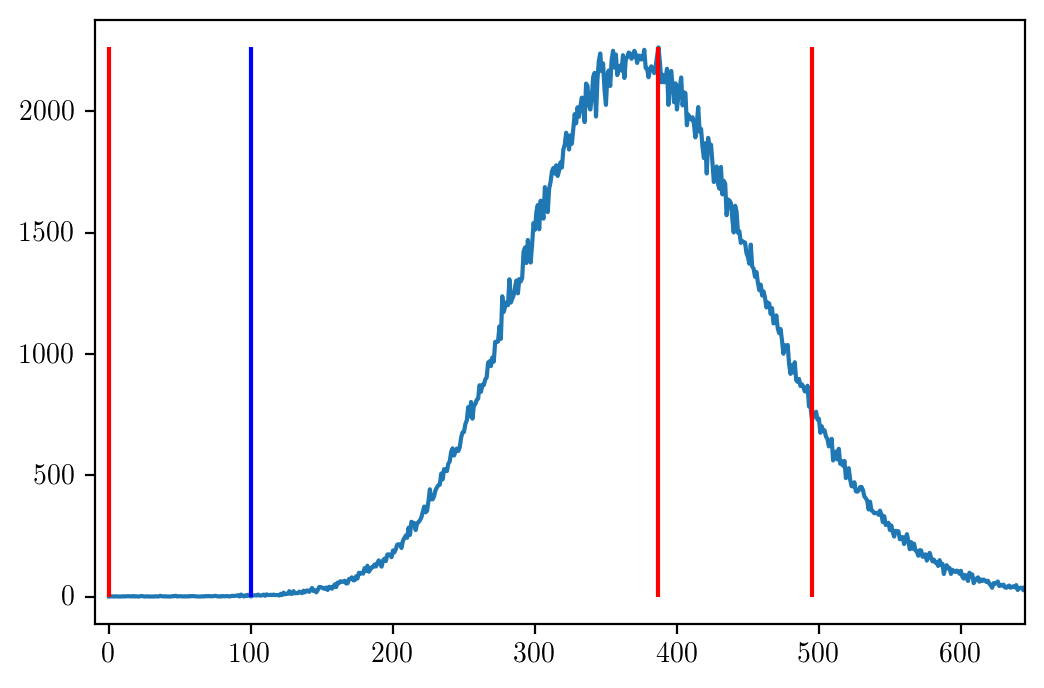

In [36]:
mpl.rcParams['figure.dpi']= 200

plt.plot(x,y)

rix_ind = 0
lix_ind = 0
rix_ind_ar = x[int(pind):][y[int(pind):] <= pdict['right_bases']]
if len(rix_ind_ar) == 0: rix_ind = (len(x)-1)
else: rix_ind = rix_ind_ar[0]
lix_ind_ar = x[:int(pind)][y[:int(pind)] <= pdict['left_bases']]
if len(lix_ind_ar) == 0: lix_ind = 0
else: lix_ind = lix_ind_ar[0]

plt.vlines(np.asarray([pind,lix_ind,rix_ind]),0,pdict['prominences'].max(),colors=['red'])
plt.vlines(np.asarray([pdict['left_bases'],pdict['right_bases']]),0,pdict['prominences'].max(),colors=['blue'])
plt.xlim(lix_ind-10,rix_ind+150)
plt.show()

In [37]:
x = x[int(pdict['right_bases']):]
y = y[int(pdict['right_bases']):]

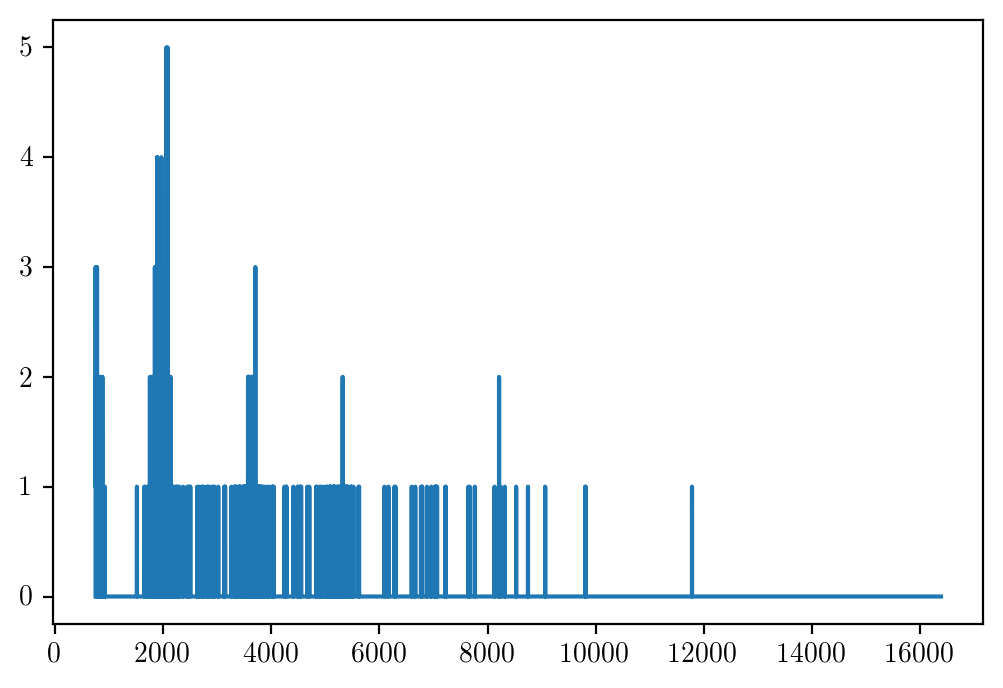

In [38]:
plt.plot(x,y)
plt.show()

In [25]:
x = x[y > 8]
y = y[y > 8]

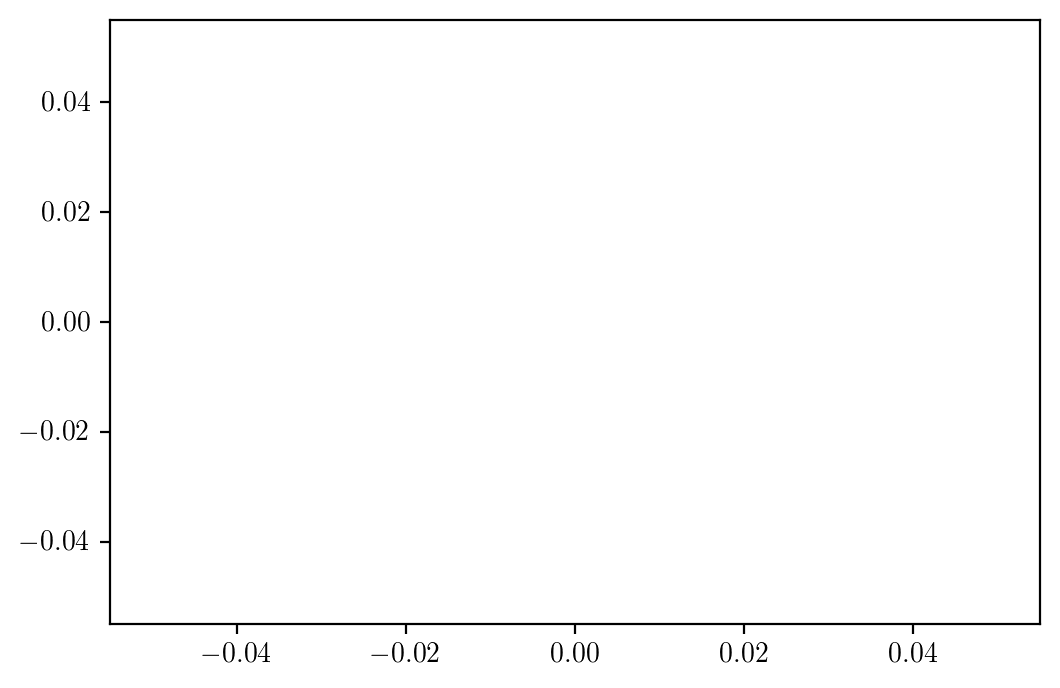

There is nothing here for me too analyze! Have a good night :)


In [26]:
plt.plot(x,y)
plt.show()

if len(x) < 10: print('There is nothing here for me too analyze! Have a good night :)')

In [29]:
files = glob.glob('/gpfs/gibbs/project/david_moore/ab2935/Data/20220811/SRS_Gain_100/Fine_Binned_Vpp/**/**/*.h5',recursive=True)
for file in natsorted(files):
    
    f = h5py.File(file, 'r')  
    ch2 = f.get('ch2')
    for key in ch2.keys(): 
        df = np.array(ch2.get(key))
    h = df
    hx = np.arange(0,len(h),1)

    pind, pdict = find_peaks(h, prominence=1000)
    print(pind)

    x = hx[int(pdict['right_bases'][0]):]
    y = h[int(pdict['right_bases'][0]):]

    x = x[y > 8]
    y = y[y > 8]

    comps = file.split(os.path.sep)
    print(f'{comps[7]} - {comps[9]} @ {comps[10]}: {comps[11]} -> ',end='')
    if len(x) > 10:
        print('\u001b[33mMAY BE USABLE\u001b[0m')
        plt.plot(x,y)
        plt.show()
    else: print('\u001b[31mUNUSABLE\u001b[0m')

[321]
20220811 - Fine_Binned_Vpp @ 3.0Vpp: 0.5kHz -> UNUSABLE
[321]
20220811 - Fine_Binned_Vpp @ 3.0Vpp: 0.5kHz -> UNUSABLE
[321]
20220811 - Fine_Binned_Vpp @ 3.0Vpp: 0.5kHz -> UNUSABLE
[324]
20220811 - Fine_Binned_Vpp @ 3.0Vpp: 0.5kHz -> UNUSABLE
[324]
20220811 - Fine_Binned_Vpp @ 3.0Vpp: 0.5kHz -> UNUSABLE
[324]
20220811 - Fine_Binned_Vpp @ 3.0Vpp: 0.5kHz -> UNUSABLE
[320]
20220811 - Fine_Binned_Vpp @ 3.0Vpp: 0.5kHz -> UNUSABLE
[320]
20220811 - Fine_Binned_Vpp @ 3.0Vpp: 0.5kHz -> UNUSABLE
[320]
20220811 - Fine_Binned_Vpp @ 3.0Vpp: 0.5kHz -> UNUSABLE
[324]
20220811 - Fine_Binned_Vpp @ 3.0Vpp: 0.5kHz -> UNUSABLE
[324]
20220811 - Fine_Binned_Vpp @ 3.0Vpp: 0.5kHz -> UNUSABLE
[324]
20220811 - Fine_Binned_Vpp @ 3.0Vpp: 0.5kHz -> UNUSABLE
[324]
20220811 - Fine_Binned_Vpp @ 3.0Vpp: 1.56kHz -> MAY BE USABLE
